# Data Sourcing

In [1]:
import pkg_resources
import pip
installedPackages = {pkg.key for pkg in pkg_resources.working_set}
required = {'researchpy', 'missingno', 'folium', 'pydotplus','bokeh','imblearn'}
missing = required - installedPackages
if missing:
    #!pip install researchpy
    #!pip install missingno
    !pip install folium
    #!pip install pydotplus
    #!pip install bokeh
    !pip install imblearn
    #!pip install xgboost
    #!pip install graphviz

In [2]:
#Disable the warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
import timeit
start_time = timeit.default_timer()  #timestamp to calculate total runtime

import pandas as pd
import numpy as np

#import researchpy as rp
#import missingno as msno
import itertools
import scipy.stats as ss

import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium import plugins
import graphviz

from sklearn import tree
from sklearn import feature_selection
from sklearn import preprocessing

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from collections import Counter

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, accuracy_score, \
precision_score, recall_score, roc_auc_score, f1_score, precision_recall_curve, auc 

%matplotlib inline
pd.set_option('display.max_columns', None)  # prevent column output trancation
sns.set()  # change plot styling from Matlab's 90s feel to today's Seaborn.

In [4]:
# File Directories
path_crashes = '../crashes.sample2020.csv'
path_vehicles = '../vehicles.sample.csv'
path_people = '../people.sample.csv'

# Import samples
crashes = pd.read_csv(path_crashes, parse_dates=["CRASH_DATE", "CRASH_DATE_EST_I", "DATE_POLICE_NOTIFIED"],
                      low_memory=False, dtype=object)
vehicles = pd.read_csv(path_vehicles, parse_dates=["CRASH_DATE"], low_memory=False, dtype=object)
people = pd.read_csv(path_people, parse_dates=["CRASH_DATE"], low_memory=False, dtype=object)

In [5]:
# Joining datasets
non_passengers=people[people.PERSON_ID.str.contains('^O')]

vehicles_with_people=vehicles.merge(non_passengers,how='left',on=['CRASH_RECORD_ID','RD_NO','CRASH_DATE','VEHICLE_ID'])

data=crashes.merge(vehicles_with_people,how='inner',on=['CRASH_RECORD_ID','RD_NO','CRASH_DATE'])

# Feature Selection
filter_list=["AGE","LANE_CNT","AIRBAG_DEPLOYED","PRIM_CONTRIBUTORY_CAUSE","POSTED_SPEED_LIMIT","NUM_UNITS","TRAFFICWAY_TYPE",  
             "SEC_CONTRIBUTORY_CAUSE","FIRST_CRASH_TYPE","MOST_SEVERE_INJURY","LIGHTING_CONDITION","SEX","CRASH_DATE",
             "CRASH_HOUR","VEHICLE_YEAR"]

# Data that will be used in predictions
modeling_data=data[filter_list]

In [6]:
# Split modeling data into raw train and test sets
raw_train, raw_test = train_test_split(modeling_data, test_size=0.20, random_state=42, shuffle=True)

# Data Preprocessing

## Preprocessing Train Set

In [7]:
def preprocessor(df):
    '''Preprocesses df and returns X and y ready for modeling (after imputation of numericals!)'''
    
    # Prepare data for missing value imputation
    df.loc[df["LIGHTING_CONDITION"] == "UNKNOWN", "LIGHTING_CONDITION"] = np.nan
    df.loc[df["TRAFFICWAY_TYPE"] == "UNKNOWN","TRAFFICWAY_TYPE"] = np.nan
    df.loc[df["AIRBAG_DEPLOYED"] == "DEPLOYMENT UNKNOWN","AIRBAG_DEPLOYED"] = np.nan
    df.fillna({'LIGHTING_CONDITION': 'DAYLIGHT', 'TRAFFICWAY_TYPE': 'NOT DIVIDED',
               'SEX': 'UNABLE TO DETERMINE', 'AIRBAG_DEPLOYED': 'UNABLE TO DETERMINE'}, inplace=True)
    
    # Remove rows missing most severe injury results
    drop_rows = ['MOST_SEVERE_INJURY']
    df.dropna(how ='any', subset = drop_rows, inplace = True)
    
    # Handle numerical features
    df['VEHICLE_YEAR'] = pd.to_numeric(df['VEHICLE_YEAR'])
    df['NUM_UNITS'] = pd.to_numeric(df['NUM_UNITS'])
    df["POSTED_SPEED_LIMIT"] = pd.to_numeric(df["POSTED_SPEED_LIMIT"])
    df["AGE"] = pd.to_numeric(df["AGE"])
    
    df['LANE_CNT'] = pd.to_numeric(df['LANE_CNT'])    
    df['LANE_CNT'].fillna(2, inplace=True)
    df.loc[(df['LANE_CNT'] > 6),'LANE_CNT'] = 6
    
    # Function definitions
    def injury(x): 
        if any(s in x for s in ["FATAL","NONINCAPACITATING INJURY","INCAPACITATING INJURY"]):
            return "INJURED"
        else:
            return "NOT INJURED"
    
    def airbag(x):
        if ("DEPLOY" in x) and ("UNKNOWN" not in x):
            if "NOT" in x:
                return "NOT DEPLOYED"
            else:
                return "DEPLOYED"
        else:
            return x

    def crash_hour(x):
        if  2 <= x < 8:
            return "Early_morning"
        elif 8 <= x < 12:
            return "Morning"
        elif 12 <= x < 18:
            return "Afternoon"
        else:
            return "Night"
  
    def traffic_way(x):
        if ("NOT" in x) or ("ONE-WAY" in x):
            return "NOT_DIVIDED"
        else:
            return "DIVIDED"
    
    # Feature Engineering
    df["INJURY"] = df["MOST_SEVERE_INJURY"].apply(lambda x: injury(x))
    df["AIRBAG_DEPLOYED"] = df["AIRBAG_DEPLOYED"].apply(lambda x: airbag(x))
    df["CRASH_HOUR"] = df["CRASH_HOUR"].apply(lambda x: crash_hour(int(x)))
    df["TRAFFICWAY_TYPE"] = df["TRAFFICWAY_TYPE"].apply(lambda x: traffic_way(x))
    
    df["VEHICLE_AGE"] = df["CRASH_DATE"].dt.year-df["VEHICLE_YEAR"]
    df.loc[df["VEHICLE_AGE"] < 0, "VEHICLE_AGE"] = 0
    df.drop(["VEHICLE_YEAR", "CRASH_DATE", "MOST_SEVERE_INJURY"], axis=1, inplace=True)
    
    # Splitting df into X and y
    y = df["INJURY"]
    X = df.drop(["INJURY"], axis=1)
    
    # Binarize y
    from sklearn.preprocessing import label_binarize
    y = preprocessing.label_binarize(y, classes=['NOT INJURED', 'INJURED'])
    
    # One-Hot Encoding
    X = pd.get_dummies(X, columns = X.select_dtypes(['object']).columns)
    dummies_to_drop = X.columns[X.columns.str.contains("UNABLE|UNKNOWN|NOT APPLICABLE|OTHER")]
    X = X.loc[:, ~X.columns.isin(dummies_to_drop)]
      
    return(X, y)

In [8]:
# Preprocess train set
X_train, y_train = preprocessor(df=raw_train)

In [9]:
# Fit imputer and impute missing values on train set 
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors = 5)
df = pd.DataFrame(imputer.fit_transform(X_train), columns = X_train.columns)
X_train = df.copy()
X_train = np.round(X_train)

In [10]:
X_train.isna().any().sum()

0

## Preprocessing Test Set

In [11]:
# Preprocess test set
X_test, y_test = preprocessor(df=raw_test)

In [12]:
# Add two trivial features of train set that doesn't exist in test set in order to use pre-fit imputer
X_test["PRIM_CONTRIBUTORY_CAUSE_OBSTRUCTED CROSSWALKS"] = 0
X_test["SEC_CONTRIBUTORY_CAUSE_PASSING STOPPED SCHOOL BUS"] = 0
X_test = X_test[X_train.columns]

In [13]:
# Impute missing values on test set by pre-fit imputer object 
df = pd.DataFrame(imputer.transform(X_test), columns = X_test.columns)
X_test = df.copy()
X_test = np.round(X_test)

In [14]:
X_test.isna().any().sum()

0

## Preprocessing EDA Train Set

In [15]:
def eda_preprocessor(df):
    '''Preprocesses and returns the entire train set for EDA'''
    
    # Split data into train test with exact indexing
    train, test = train_test_split(df, test_size=0.20, random_state=42, shuffle=True)
    
    # Feature reduction
    drop=["CRASH_DATE_EST_I", "REPORT_TYPE", "CRASH_DATE_EST_I", "REPORT_TYPE", "DATE_POLICE_NOTIFIED",
          "BEAT_OF_OCCURRENCE", "PHOTOS_TAKEN_I", "STATEMENTS_TAKEN_I", "WORK_ZONE_TYPE", "WORKERS_PRESENT_I", 
          "INJURIES_NO_INDICATION", "INJURIES_UNKNOWN", "CRASH_DAY_OF_WEEK", "CRASH_MONTH", "RD_NO", "VEHICLE_ID", 
          "CRASH_RECORD_ID", "SEAT_NO", "STATE", "ZIPCODE", "DRIVERS_LICENSE_STATE", "PERSON_ID", "DRIVERS_LICENSE_CLASS", 
          "INJURY_CLASSIFICATION", "HOSPITAL", "EMS_AGENCY", "EMS_RUN_NO", "PEDPEDAL_LOCATION", "LOCATION",
          "DAMAGE", "CRASH_TYPE", "MODEL", "BAC_RESULT", "CRASH_UNIT_ID", "RD_NO", "UNIT_NO", "UNIT_TYPE", 
          "VEHICLE_ID", "CMRC_VEH_I", "MAKE", "TOWED_I", "FIRE_I", "TOWED_BY", "STREET_NO","STREET_NAME",
          "TOWED_TO", "AREA_00_I", "AREA_01_I", "AREA_02_I", "AREA_03_I", "AREA_04_I", "AREA_05_I", "AREA_06_I", 
          "AREA_07_I", "AREA_08_I", "AREA_09_I", "AREA_10_I", "AREA_11_I", "AREA_12_I", "AREA_99_I", "CMV_ID", 
          "USDOT_NO", "CCMC_NO", "ILCC_NO", "COMMERCIAL_SRC", "GVWR", "CARRIER_NAME", "CARRIER_STATE", 
          "CARRIER_CITY", "HAZMAT_PLACARDS_I", "HAZMAT_NAME", "UN_NO", "HAZMAT_PRESENT_I", "HAZMAT_REPORT_I",
          "HAZMAT_REPORT_NO", "MCS_REPORT_I", "MCS_REPORT_NO", "HAZMAT_VIO_CAUSE_CRASH_I", "MCS_VIO_CAUSE_CRASH_I", 
          "IDOT_PERMIT_NO", "WIDE_LOAD_I", "TRAILER1_WIDTH", "TRAILER2_WIDTH", "TRAILER1_LENGTH", "TRAILER2_LENGTH", 
          "TOTAL_VEHICLE_LENGTH", "AXLE_CNT", "VEHICLE_CONFIG", "CARGO_BODY_TYPE", "LOAD_TYPE", "HAZMAT_OUT_OF_SERVICE_I",
          "INJURIES_REPORTED_NOT_EVIDENT", "INJURIES_NON_INCAPACITATING", #"INJURIES_FATAL","INJURIES_INCAPACITATING",
          "MCS_OUT_OF_SERVICE_I", "HAZMAT_CLASS"]
    
    train = train.loc[:, ~train.columns.isin(drop)]
    
    
    # Prepare data for missing value imputation
    train.loc[train["TRAFFIC_CONTROL_DEVICE"]=="UNKNOWN","TRAFFIC_CONTROL_DEVICE"]=np.nan
    train.loc[train["DEVICE_CONDITION"]=="UNKNOWN","DEVICE_CONDITION"]=np.nan
    train.loc[train["WEATHER_CONDITION"]=="UNKNOWN","WEATHER_CONDITION"]=np.nan
    train.loc[train["LIGHTING_CONDITION"]=="UNKNOWN","LIGHTING_CONDITION"]=np.nan
    train.loc[train["TRAFFICWAY_TYPE"]=="UNKNOWN","TRAFFICWAY_TYPE"]=np.nan
    train.loc[train["ROADWAY_SURFACE_COND"]=="UNKNOWN","ROADWAY_SURFACE_COND"]=np.nan
    train.loc[train["ROAD_DEFECT"]=="UNKNOWN","ROAD_DEFECT"]=np.nan

    train.loc[train["VEHICLE_DEFECT"]=="UNKNOWN","VEHICLE_DEFECT"]=np.nan
    train.loc[train["VEHICLE_TYPE"]=="UNKNOWN/NA","VEHICLE_TYPE"]=np.nan
    train.loc[train["TRAVEL_DIRECTION"]=="UNKNOWN","TRAVEL_DIRECTION"]=np.nan
    train.loc[train["MANEUVER"]=="UNKNOWN/NA","MANEUVER"]=np.nan

    train.loc[train["SAFETY_EQUIPMENT"]=="USAGE UNKNOWN","SAFETY_EQUIPMENT"]=np.nan
    train.loc[train["AIRBAG_DEPLOYED"]=="DEPLOYMENT UNKNOWN","AIRBAG_DEPLOYED"]=np.nan
    train.loc[train["EJECTION"]=="UNKNOWN","EJECTION"]=np.nan
    train.loc[train["DRIVER_ACTION"]=="UNKNOWN","DRIVER_ACTION"]=np.nan
    train.loc[train["DRIVER_VISION"]=="UNKNOWN","DRIVER_VISION"]=np.nan
    train.loc[train["PHYSICAL_CONDITION"]=="UNKNOWN","PHYSICAL_CONDITION"]=np.nan
    train.loc[train["PEDPEDAL_ACTION"]=="UNKNOWN/NA","PEDPEDAL_ACTION"]=np.nan
    
    
    # Mıssing Value Imputation
    train.fillna({
        'TRAFFIC_CONTROL_DEVICE': 'NO CONTROLS',
        'DEVICE_CONDITION': 'NO CONTROLS',
        'WEATHER_CONDITION': 'CLEAR',
        'LIGHTING_CONDITION': 'DAYLIGHT', # ??
        'TRAFFICWAY_TYPE': 'NOT DIVIDED', # ??
        'ROADWAY_SURFACE_COND': 'NO DEFECTS',
        'ROAD_DEFECT': 'CLEAR',
        'INTERSECTION_RELATED_I': 'N',
    
        'NOT_RIGHT_OF_WAY_I': 'N',
        'HIT_AND_RUN_I': 'N',
        'DOORING_I': 'N',
        'WORK_ZONE_I': 'N',
        'NUM_PASSENGERS': 0,
        'LIC_PLATE_STATE': 'IL',
        'VEHICLE_DEFECT': 'UNABLE TO DETERMINE',
        'VEHICLE_TYPE': 'OTHER',

        'VEHICLE_USE': 'OTHER',
        'TRAVEL_DIRECTION': 'N',
        'MANEUVER': 'OTHER',
        'OCCUPANT_CNT': 0,
        'EXCEED_SPEED_LIMIT_I': 'N',
        'FIRST_CONTACT_POINT': 'OTHER',
        'PERSON_TYPE': 'UNABLE TO DETERMINE',
        'CITY': 'OTHER',

        'SEX': 'UNABLE TO DETERMINE',
        'AIRBAG_DEPLOYED': 'UNABLE TO DETERMINE',
        'EJECTION': 'UNABLE TO DETERMINE',
        'DRIVER_ACTION': 'OTHER',
        'DRIVER_VISION': 'OTHER',
        'PHYSICAL_CONDITION': 'UNABLE TO DETERMINE',
        'PEDPEDAL_ACTION': 'UNABLE TO DETERMINE',
        'PEDPEDAL_VISIBILITY': 'UNABLE TO DETERMINE',

        'CELL_PHONE_USE': 'UNABLE TO DETERMINE',
        'SAFETY_EQUIPMENT': 'UNABLE TO DETERMINE',
        'BAC_RESULT VALUE': 0
    }, inplace=True)
    
    
    # Drop rows with missing values in these features
    drop_rows = ['INJURIES_TOTAL', 'LATITUDE', 'MOST_SEVERE_INJURY']
    train.dropna(how = 'any', subset = drop_rows, inplace = True)
    

    # Handle numerical features
    train['LANE_CNT'] = pd.to_numeric(train['LANE_CNT'])
    train['VEHICLE_YEAR'] = pd.to_numeric(train['VEHICLE_YEAR'])
    train['NUM_UNITS'] = pd.to_numeric(train['NUM_UNITS'])
    train["POSTED_SPEED_LIMIT"] = pd.to_numeric(train["POSTED_SPEED_LIMIT"])
    train["AGE"] = pd.to_numeric(train["AGE"])
    train["INJURIES_FATAL"] = pd.to_numeric(train["INJURIES_FATAL"])
    train["INJURIES_INCAPACITATING"] = pd.to_numeric(train["INJURIES_INCAPACITATING"])
    train["INJURIES_TOTAL"] = pd.to_numeric(train["INJURIES_TOTAL"])
    
    train['TOTAL_FATAL'] = train['INJURIES_FATAL'] + train['INJURIES_INCAPACITATING']
    train['TOTAL_FATAL'] = pd.to_numeric(train['TOTAL_FATAL'])

    train['LANE_CNT'] = pd.to_numeric(train['LANE_CNT'])    
    train['LANE_CNT'].fillna(2, inplace=True)
    train.loc[(train['LANE_CNT'] > 6),'LANE_CNT'] = 6
    
    
    # Function definitions
    def injury(x): 
        if any(s in x for s in ["FATAL","NONINCAPACITATING INJURY","INCAPACITATING INJURY"]):
            return "INJURED"
        else:
            return "NOT INJURED"
        
    def fatalities(x): 
        if any(s in x for s in ["FATAL"]):
            return "FATAL"
        else:
            return "NOT FATAL"
    
    def airbag(x):
        if ("DEPLOY" in x) and ("UNKNOWN" not in x):
            if "NOT" in x:
                return "NOT DEPLOYED"
            else:
                return "DEPLOYED"
        else:
            return x
  
    def traffic_way(x):
        if ("NOT" in x) or ("ONE-WAY" in x):
            return "NOT_DIVIDED"
        else:
            return "DIVIDED"
        
    def contact_point(x):
        if "FRONT" in x:
            return "FRONT"
        elif "SIDE" in x:
            return "SIDE"
        elif "REAR" in x:
            return "REAR"
        else:
            return "OTHER"
    
    def equip_used(x):
        if ("USED" in x) or ("HELMET" in x) or ("NONE PRESENT" in x):
            if any(s in x for s in ["NOT","IMPROPER","NONE PRESENT"]):
                return "DID NOT USE SAFETY EQUIP"
            else:
                return "USED SAFETY EQUIP"
        else:
            return x

    def airbag(x):
        if ("DEPLOY" in x) and ("UNKNOWN" not in x):
            if "NOT" in x:
                return "NOT DEPLOYED"
            else:
                return "DEPLOYED"
        else:
            return x
    
    def crash_hour(x):
        if  2 <= x < 8:
            return "Early_morning"
        elif 8 <= x < 12:
            return "Morning"
        elif 12 <= x < 18:
            return "Afternoon"
        else:
            return "Night"

    def traffic_control(x):
        if ("NO CONTROLS" in x) or ("UNKNOWN" in x) or ("OTHER" in x):
            return "NO_SIGN"
        else:
            return "SIGN"
    
    def location(x1,x2):
        if (41.84 <= float(x1) <= 41.9100064) and (-87.7421459 <= float(x2) <= -87.50):
            return "Downtown"
        else:
            return "Not Downtown"

        
    # Feature engineering
    train["INJURY"] = train["MOST_SEVERE_INJURY"].apply(lambda x: injury(x))
    train["FATALITIES"] = train["MOST_SEVERE_INJURY"].apply(lambda x: fatalities(x))
    train["AIRBAG_DEPLOYED"] = train["AIRBAG_DEPLOYED"].apply(lambda x: airbag(x))
    train["CRASH_HOUR"] = train["CRASH_HOUR"].apply(lambda x: crash_hour(int(x)))
    train["TRAFFICWAY_TYPE"] = train["TRAFFICWAY_TYPE"].apply(lambda x: traffic_way(x))
    train["FIRST_CONTACT_POINT"] = train["FIRST_CONTACT_POINT"].apply(lambda x: contact_point(x))
    train["MANEUVER"] = train["MANEUVER"].apply(lambda x: "TURN" if "TURN" in x else("LANE" if any(s in x for s in ["LANE","OVER","ENTER"]) else x))
    train["MANEUVER"] = train["MANEUVER"].apply(lambda x: "OTHER" if all(s not in x for s in ["AHEAD","TURN","UNKNOWN","LANE","BACKING"]) else x)
    train["SAFETY_EQUIPMENT"] = train["SAFETY_EQUIPMENT"].apply(lambda x: equip_used(x))
    train["AIRBAG_DEPLOYED"] = train["AIRBAG_DEPLOYED"].apply(lambda x: airbag(x))
    train["TRAFFIC_CONTROL_DEVICE"]= train["TRAFFIC_CONTROL_DEVICE"].apply(lambda x: traffic_control(x))
    train["Location"] = train.apply(lambda x: location(x["LATITUDE"], x["LONGITUDE"]), axis = 1)
    
    train["VEHICLE_AGE"] = train["CRASH_DATE"].dt.year-train["VEHICLE_YEAR"]
    train.loc[train["VEHICLE_AGE"] < 0, "VEHICLE_AGE"] = 0
    train.drop(["VEHICLE_YEAR", "MOST_SEVERE_INJURY"], axis=1, inplace=True)  # "CRASH_DATE" for Tony
     
    # Return only train set for EDA purposes     
    return(train)

In [16]:
train = eda_preprocessor(data)

# Comparison of Imputation Methods

# Catboost

In [17]:
#drop_list =["LATITUDE","LONGITUDE","INJURIES_TOTAL","CRASH_DATE","INJURY","FATALITIES"]
#train_new = train.drop(drop_list, axis=1)
#train_new = train[(train.PRIM_CONTRIBUTORY_CAUSE != 'UNABLE TO DETERMINE') & (train.PRIM_CONTRIBUTORY_CAUSE != 'NOT APPLICABLE')]

In [18]:
#X_train = train_new.drop(["PRIM_CONTRIBUTORY_CAUSE"],axis=1).reset_index(drop=True)
#y_train = train_new["PRIM_CONTRIBUTORY_CAUSE"]
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

# Bootstrapped CIs for Model Results

In [19]:
# Random Undersampling on X and y train sets
under = RandomUnderSampler(sampling_strategy=1)
X_under, y_under = under.fit_resample(X_train, y_train)

In [20]:
# Store n_bootstraps number of bootstrap samples of X and y dataframes in lists
n_bootstraps = 100
bootstrap_X = []
bootstrap_y = []
for _ in range(n_bootstraps):
    sample_X, sample_y = resample(X_under, y_under)
    bootstrap_X.append(sample_X)
    bootstrap_y.append(sample_y)

In [21]:
# Random Forest model with tuned hyperparameters
random_final = RandomForestClassifier(n_estimators=1000, min_samples_split=15, min_samples_leaf=5, 
                                      max_features='log2', max_depth=13, criterion='entropy')

# Predict n_bootstraps number of bootstrapped samples and store recall results
recall_scores = []
for i, data in enumerate(bootstrap_X):
    model = random_final.fit(data, bootstrap_y[i])
    y_pred = model.predict(X_test)
    recall_scores.append(recall_score(y_test, y_pred))
    # model.feature_importance_

KeyboardInterrupt: 

In [ ]:
# Plot scores
plt.hist(recall_scores)
plt.show()

# Confidence intervals
alpha = 0.95
p = ((1.0 - alpha) / 2.0) * 100
lower = max(0.0, np.percentile(recall_scores, p))
p = (alpha + ((1.0 - alpha) / 2.0)) * 100
upper = min(1.0, np.percentile(recall_scores, p))

print('%.1f confidence interval for recall %.1f%% and %.1f%% across %.d bootstrapped predictions.' % (alpha*100, lower*100, upper*100, n_bootstraps))

In [ ]:
#elapsed = timeit.default_timer() - start_time
#print('Total runtime is', round(elapsed, 2)/60, 'minutes.')

# Further Analysis

## Summary of Injuries Fatalities 

**Inferences**

- **14% of fatalities** and **10% of injuries** happened to **people aged over 60**.
- **12% of fatalities** and **11% of injuries** happened in **vehicles aged over 15**. (Which VEHICLE_TYPE ?)

- GET COORDINATES OF NEIGHBORHOODS


- **25% of fatalities** and **13% of injuries** happened to **cyclers with no contrasting clothing**
- **6% of injuries** happened to pedestrians or pedalists **while crossing the road**.
- **5% of fatalities** and **12% of injuries** happened where drivers were **failed to yield**.
 - **PRIM CAUSES?**
 - FAILING TO REDUCE SPEED TO AVOID CRASH	0.09	0.22
 - PHYSICAL CONDITION OF DRIVER	0.03	0.16
 - FAILING TO YIELD RIGHT-OF-WAY	0.20	0.08
 - OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELE...	0.03	0.08
 
 - **SEC CAUSE**
 - FAILING TO YIELD RIGHT-OF-WAY	0.05	0.20


- **8% of fatalities** happened where drivers were **too fast for conditions**.
- **16% of fatalities** and **35% of injuries** happened in which **cars were failed to deploy airbags**.

- **14% of fatalities** and **13% of injuries** happened to **drivers failed to use safety equipment**.
- **22% of fatalities** and **11% of injuries** happened to **pedestrians**.

- **5% of fatalities** and **1% of injuries** happened in **the excess of speed limits**.
 - NUM_UNITS ?


- **11% of fatalities** and **16% of injuries** happened in **wet roads**.

- **39% of fatalities** and **47% of injuries** happened in **collisions straight ahead**.
- **5% of fatalities** and **12% of injuries** happened in **a turn maneuver**.
 - Night	0.33	0.55


- HIT AND RUN YES 0.21	0.25

- INTERSETION RELATED Y	0.42	0.53, ANY CONTROL DEVICE?


**IN UNFORMATTED LEVELS, right value is fatal (0.53), left value is injured (0.42)**

In [22]:
def injury_fatality_summarizer(col, df=train):
    x=df[df['INJURY']=='INJURED'][col].value_counts(normalize=True).reset_index(name='injury')
    y=df[df['FATALITIES']=='FATAL'][col].value_counts(normalize=True).reset_index(name='fatal')
    
    table=x.merge(y, how='inner', on=['index']).sort_values(['fatal','injury'], ascending=False)
    table=table.rename(columns={'index':col, 'injury':'PERCENTAGE OF INJURIES', 'fatal':'PERCENTAGE OF FATALITIES'})
    return(table[:12].round(2))

In [23]:
from IPython.core import display as ICD

for col in train.columns:
    table = injury_fatality_summarizer(col)
    ICD.display(table)

,CRASH_DATE,PERCENTAGE OF INJURIES,PERCENTAGE OF FATALITIES
0,2018-04-10 18:20:00,0.0,0.20
1,2018-03-16 16:27:00,0.0,0.06
2,2018-03-23 20:44:00,0.0,0.06
3,2020-06-03 21:57:00,0.0,0.05
4,2019-01-27 01:20:00,0.0,0.05
5,2018-06-01 00:18:00,0.0,0.05
6,2020-03-11 13:10:00,0.0,0.03
7,2018-01-20 21:40:00,0.0,0.03
8,2018-09-23 17:20:00,0.0,0.03
9,2018-08-17 12:41:00,0.0,0.03


,POSTED_SPEED_LIMIT,PERCENTAGE OF INJURIES,PERCENTAGE OF FATALITIES
0,30,0.78,0.66
1,35,0.10,0.30
3,40,0.02,0.03
2,25,0.05,0.02


,TRAFFIC_CONTROL_DEVICE,PERCENTAGE OF INJURIES,PERCENTAGE OF FATALITIES
1,NO_SIGN,0.45,0.55
0,SIGN,0.55,0.45


,DEVICE_CONDITION,PERCENTAGE OF INJURIES,PERCENTAGE OF FATALITIES
0,FUNCTIONING PROPERLY,0.50,0.5
1,NO CONTROLS,0.48,0.5


,WEATHER_CONDITION,PERCENTAGE OF INJURIES,PERCENTAGE OF FATALITIES
0,CLEAR,0.82,0.80
1,RAIN,0.11,0.08
2,CLOUDY/OVERCAST,0.03,0.08
3,SNOW,0.03,0.05


,LIGHTING_CONDITION,PERCENTAGE OF INJURIES,PERCENTAGE OF FATALITIES
0,DAYLIGHT,0.62,0.56
1,"DARKNESS, LIGHTED ROAD",0.29,0.39
2,DARKNESS,0.05,0.05


,FIRST_CRASH_TYPE,PERCENTAGE OF INJURIES,PERCENTAGE OF FATALITIES
3,TURNING,0.16,0.23
5,PARKED MOTOR VEHICLE,0.08,0.16
0,PEDESTRIAN,0.19,0.14
1,ANGLE,0.18,0.11
7,FIXED OBJECT,0.03,0.09
4,PEDALCYCLIST,0.09,0.08
9,SIDESWIPE OPPOSITE DIRECTION,0.01,0.06
2,REAR END,0.17,0.05
6,SIDESWIPE SAME DIRECTION,0.06,0.03
10,REAR TO FRONT,0.00,0.03


,TRAFFICWAY_TYPE,PERCENTAGE OF INJURIES,PERCENTAGE OF FATALITIES
0,NOT_DIVIDED,0.75,0.92
1,DIVIDED,0.25,0.08


,LANE_CNT,PERCENTAGE OF INJURIES,PERCENTAGE OF FATALITIES
0,2.0,0.82,0.58
1,4.0,0.10,0.31
2,1.0,0.03,0.05
4,6.0,0.01,0.03
3,3.0,0.02,0.02
5,5.0,0.01,0.02


,ALIGNMENT,PERCENTAGE OF INJURIES,PERCENTAGE OF FATALITIES
0,STRAIGHT AND LEVEL,0.97,0.92
2,"CURVE, LEVEL",0.01,0.06
1,STRAIGHT ON GRADE,0.01,0.02


,ROADWAY_SURFACE_COND,PERCENTAGE OF INJURIES,PERCENTAGE OF FATALITIES
0,DRY,0.77,0.75
1,WET,0.16,0.11
2,NO DEFECTS,0.03,0.09
3,ICE,0.01,0.05


,ROAD_DEFECT,PERCENTAGE OF INJURIES,PERCENTAGE OF FATALITIES
0,NO DEFECTS,0.86,0.86
1,CLEAR,0.12,0.14


,INTERSECTION_RELATED_I,PERCENTAGE OF INJURIES,PERCENTAGE OF FATALITIES
1,Y,0.42,0.53
0,N,0.58,0.47


,NOT_RIGHT_OF_WAY_I,PERCENTAGE OF INJURIES,PERCENTAGE OF FATALITIES
0,N,0.98,0.98
1,Y,0.02,0.02


,HIT_AND_RUN_I,PERCENTAGE OF INJURIES,PERCENTAGE OF FATALITIES
0,N,0.79,0.75
1,Y,0.21,0.25


,PRIM_CONTRIBUTORY_CAUSE,PERCENTAGE OF INJURIES,PERCENTAGE OF FATALITIES
0,UNABLE TO DETERMINE,0.25,0.34
2,FAILING TO REDUCE SPEED TO AVOID CRASH,0.09,0.22
4,PHYSICAL CONDITION OF DRIVER,0.03,0.16
1,FAILING TO YIELD RIGHT-OF-WAY,0.20,0.08
5,"OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELE...",0.03,0.08
3,DISREGARDING TRAFFIC SIGNALS,0.06,0.03
6,IMPROPER LANE USAGE,0.02,0.03
7,DRIVING ON WRONG SIDE/WRONG WAY,0.01,0.02
8,EXCEEDING AUTHORIZED SPEED LIMIT,0.01,0.02
9,DISTRACTION - FROM INSIDE VEHICLE,0.01,0.02


,SEC_CONTRIBUTORY_CAUSE,PERCENTAGE OF INJURIES,PERCENTAGE OF FATALITIES
1,UNABLE TO DETERMINE,0.30,0.41
0,NOT APPLICABLE,0.37,0.20
3,FAILING TO YIELD RIGHT-OF-WAY,0.05,0.20
4,"OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELE...",0.02,0.08
7,DISREGARDING ROAD MARKINGS,0.00,0.03
8,DISREGARDING YIELD SIGN,0.00,0.03
2,FAILING TO REDUCE SPEED TO AVOID CRASH,0.07,0.02
5,WEATHER,0.02,0.02
6,EXCEEDING AUTHORIZED SPEED LIMIT,0.01,0.02


,STREET_DIRECTION,PERCENTAGE OF INJURIES,PERCENTAGE OF FATALITIES
1,S,0.34,0.45
0,W,0.36,0.28
3,E,0.07,0.22
2,N,0.22,0.05


,DOORING_I,PERCENTAGE OF INJURIES,PERCENTAGE OF FATALITIES
0,N,0.99,1.0


,WORK_ZONE_I,PERCENTAGE OF INJURIES,PERCENTAGE OF FATALITIES
0,N,1.0,1.0


,NUM_UNITS,PERCENTAGE OF INJURIES,PERCENTAGE OF FATALITIES
0,2,0.71,0.48
1,4,0.06,0.22
3,6,0.02,0.20
2,1,0.03,0.09


,INJURIES_TOTAL,PERCENTAGE OF INJURIES,PERCENTAGE OF FATALITIES
0,1,0.72,0.53
4,7,0.00,0.20
1,2,0.18,0.09
2,4,0.03,0.06
3,5,0.01,0.06
5,6,0.00,0.05


,INJURIES_FATAL,PERCENTAGE OF INJURIES,PERCENTAGE OF FATALITIES
0,1,0.01,0.94
1,2,0.00,0.06


,INJURIES_INCAPACITATING,PERCENTAGE OF INJURIES,PERCENTAGE OF FATALITIES
0,0,0.80,0.62
1,1,0.17,0.30
3,5,0.00,0.05
2,2,0.02,0.03


,CRASH_HOUR,PERCENTAGE OF INJURIES,PERCENTAGE OF FATALITIES
1,Night,0.33,0.55
0,Afternoon,0.37,0.22
3,Early_morning,0.13,0.12
2,Morning,0.17,0.11


,LATITUDE,PERCENTAGE OF INJURIES,PERCENTAGE OF FATALITIES
0,41.722449457,0.0,0.20
2,41.668662762,0.0,0.06
3,41.846953533,0.0,0.06
1,41.659042578,0.0,0.05
4,41.764690755,0.0,0.05
5,41.954399304,0.0,0.05
6,41.786209671,0.0,0.03
7,41.997237289,0.0,0.03
8,41.960991075,0.0,0.03
9,41.78592859,0.0,0.03


,LONGITUDE,PERCENTAGE OF INJURIES,PERCENTAGE OF FATALITIES
0,-87.585003569,0.0,0.20
2,-87.734240501,0.0,0.06
3,-87.638141872,0.0,0.06
1,-87.540033559,0.0,0.05
4,-87.669112865,0.0,0.05
5,-87.674598427,0.0,0.05
6,-87.740826883,0.0,0.03
7,-87.714836838,0.0,0.03
8,-87.836845792,0.0,0.03
9,-87.75621475,0.0,0.03


,NUM_PASSENGERS,PERCENTAGE OF INJURIES,PERCENTAGE OF FATALITIES
0,0,0.77,0.73
1,1,0.15,0.16
2,2,0.05,0.06
3,3,0.02,0.05


,LIC_PLATE_STATE,PERCENTAGE OF INJURIES,PERCENTAGE OF FATALITIES
0,IL,0.93,0.95
2,XX,0.02,0.03
1,IN,0.02,0.02


,VEHICLE_DEFECT,PERCENTAGE OF INJURIES,PERCENTAGE OF FATALITIES
0,UNABLE TO DETERMINE,0.53,0.78
1,NONE,0.46,0.17
2,OTHER,0.00,0.05


,VEHICLE_TYPE,PERCENTAGE OF INJURIES,PERCENTAGE OF FATALITIES
0,PASSENGER,0.58,0.52
1,OTHER,0.21,0.33
2,SPORT UTILITY VEHICLE (SUV),0.10,0.09
4,PICKUP,0.02,0.03
3,VAN/MINI-VAN,0.04,0.02
5,MOTORCYCLE (OVER 150CC),0.01,0.02


,VEHICLE_USE,PERCENTAGE OF INJURIES,PERCENTAGE OF FATALITIES
0,PERSONAL,0.62,0.45
1,OTHER,0.18,0.27
2,UNKNOWN/NA,0.11,0.16
3,NOT IN USE,0.03,0.09
4,TAXI/FOR HIRE,0.01,0.02
5,TOW TRUCK,0.00,0.02


,TRAVEL_DIRECTION,PERCENTAGE OF INJURIES,PERCENTAGE OF FATALITIES
0,N,0.38,0.56
1,S,0.20,0.20
3,E,0.19,0.12
2,W,0.19,0.11


,MANEUVER,PERCENTAGE OF INJURIES,PERCENTAGE OF FATALITIES
1,OTHER,0.36,0.55
0,STRAIGHT AHEAD,0.47,0.39
2,TURN,0.12,0.05
3,LANE,0.03,0.02


,OCCUPANT_CNT,PERCENTAGE OF INJURIES,PERCENTAGE OF FATALITIES
0,1,0.55,0.38
1,0,0.16,0.25
2,2,0.15,0.16
3,0,0.07,0.11
4,3,0.05,0.06
5,4,0.02,0.05


,EXCEED_SPEED_LIMIT_I,PERCENTAGE OF INJURIES,PERCENTAGE OF FATALITIES
0,N,0.99,0.95
1,Y,0.01,0.05


,FIRST_CONTACT_POINT,PERCENTAGE OF INJURIES,PERCENTAGE OF FATALITIES
0,OTHER,0.45,0.47
1,FRONT,0.32,0.34
2,REAR,0.16,0.11
3,SIDE,0.08,0.08


,PERSON_TYPE,PERCENTAGE OF INJURIES,PERCENTAGE OF FATALITIES
0,DRIVER,0.77,0.62
1,PEDESTRIAN,0.11,0.22
2,UNABLE TO DETERMINE,0.08,0.11
3,BICYCLE,0.04,0.03
4,NON-CONTACT VEHICLE,0.00,0.02


,CITY,PERCENTAGE OF INJURIES,PERCENTAGE OF FATALITIES
0,CHICAGO,0.60,0.58
1,OTHER,0.19,0.23
2,CICERO,0.01,0.03
3,BERWYN,0.01,0.03
4,PARK RIDGE,0.00,0.02
5,PLAINFIELD,0.00,0.02
6,GARY,0.00,0.02
7,MIDLOTHIAN,0.00,0.02
8,CALUMET,0.00,0.02
9,ROCKFORD,0.00,0.02


,SEX,PERCENTAGE OF INJURIES,PERCENTAGE OF FATALITIES
0,M,0.53,0.52
1,F,0.35,0.30
2,UNABLE TO DETERMINE,0.08,0.11
3,X,0.04,0.08


,AGE,PERCENTAGE OF INJURIES,PERCENTAGE OF FATALITIES
23,67.0,0.01,0.11
11,21.0,0.02,0.09
2,24.0,0.03,0.06
9,33.0,0.02,0.06
10,20.0,0.02,0.06
13,37.0,0.02,0.06
27,5.0,0.00,0.06
8,22.0,0.02,0.04
19,50.0,0.01,0.04
0,28.0,0.03,0.02


,SAFETY_EQUIPMENT,PERCENTAGE OF INJURIES,PERCENTAGE OF FATALITIES
0,UNABLE TO DETERMINE,0.48,0.67
1,USED SAFETY EQUIP,0.39,0.19
2,DID NOT USE SAFETY EQUIP,0.13,0.14


,AIRBAG_DEPLOYED,PERCENTAGE OF INJURIES,PERCENTAGE OF FATALITIES
0,UNABLE TO DETERMINE,0.36,0.53
2,DEPLOYED,0.20,0.28
1,NOT DEPLOYED,0.35,0.16
3,NOT APPLICABLE,0.09,0.03


,EJECTION,PERCENTAGE OF INJURIES,PERCENTAGE OF FATALITIES
0,NONE,0.75,0.45
1,UNABLE TO DETERMINE,0.23,0.45
2,TOTALLY EJECTED,0.02,0.05
3,TRAPPED/EXTRICATED,0.00,0.05


,DRIVER_ACTION,PERCENTAGE OF INJURIES,PERCENTAGE OF FATALITIES
0,OTHER,0.37,0.56
1,NONE,0.34,0.27
4,TOO FAST FOR CONDITIONS,0.02,0.08
2,FAILED TO YIELD,0.12,0.05
3,DISREGARDED CONTROL DEVICES,0.04,0.02
5,IMPROPER LANE CHANGE,0.01,0.02
6,EVADING POLICE VEHICLE,0.00,0.02


,DRIVER_VISION,PERCENTAGE OF INJURIES,PERCENTAGE OF FATALITIES
1,OTHER,0.48,0.73
0,NOT OBSCURED,0.50,0.22
3,PARKED VEHICLES,0.00,0.03
2,MOVING VEHICLES,0.01,0.02


,PHYSICAL_CONDITION,PERCENTAGE OF INJURIES,PERCENTAGE OF FATALITIES
1,UNABLE TO DETERMINE,0.28,0.50
0,NORMAL,0.65,0.41
2,REMOVED BY EMS,0.03,0.05
3,OTHER,0.01,0.03
4,EMOTIONAL,0.01,0.02


,PEDPEDAL_ACTION,PERCENTAGE OF INJURIES,PERCENTAGE OF FATALITIES
0,UNABLE TO DETERMINE,0.86,0.78
2,NO ACTION,0.01,0.17
3,NOT AT INTERSECTION,0.01,0.03
1,OTHER ACTION,0.02,0.02


,PEDPEDAL_VISIBILITY,PERCENTAGE OF INJURIES,PERCENTAGE OF FATALITIES
0,UNABLE TO DETERMINE,0.84,0.75
1,NO CONTRASTING CLOTHING,0.13,0.25


,BAC_RESULT VALUE,PERCENTAGE OF INJURIES,PERCENTAGE OF FATALITIES
0,0,1.0,1.0


,CELL_PHONE_USE,PERCENTAGE OF INJURIES,PERCENTAGE OF FATALITIES
0,UNABLE TO DETERMINE,1.0,1.0


,TOTAL_FATAL,PERCENTAGE OF INJURIES,PERCENTAGE OF FATALITIES
0,1,0.17,0.62
1,2,0.02,0.27
4,6,0.00,0.05
2,3,0.01,0.03
3,4,0.00,0.03


,INJURY,PERCENTAGE OF INJURIES,PERCENTAGE OF FATALITIES
0,INJURED,1.0,1.0


,FATALITIES,PERCENTAGE OF INJURIES,PERCENTAGE OF FATALITIES
0,FATAL,0.01,1.0


,Location,PERCENTAGE OF INJURIES,PERCENTAGE OF FATALITIES
0,Not Downtown,0.74,0.8
1,Downtown,0.26,0.2


,VEHICLE_AGE,PERCENTAGE OF INJURIES,PERCENTAGE OF FATALITIES
13,15.0,0.04,0.17
9,11.0,0.05,0.10
3,2.0,0.06,0.07
4,5.0,0.06,0.07
5,6.0,0.05,0.07
7,7.0,0.05,0.05
8,0.0,0.05,0.05
10,13.0,0.04,0.05
11,14.0,0.04,0.05
16,17.0,0.03,0.05


## Time-Based Findings

**Overview Structure based on Time**

- There is **at least 7 traffic crashes** in Chicago **on a daily basis**.


- **At least 11 people** are injured in a traffic crash **every day**!


- **Everyday, at least 2 people die or face with fatal injuries** in a traffic crash in Chicago!


- **Death and serious injuries** from traffic crashes **increased by 8% by each year**!

In [24]:
# Convert crash_data into time
train['CRASH_DATE'] = pd.to_datetime(train.CRASH_DATE)
train['CRASH_DATE_NEW'] = pd.to_datetime(train['CRASH_DATE']).dt.date
#train['CRASH_DATE_NEW']

In [25]:
df = train.copy()
from datetime import datetime, date
#df[df['CRASH_DATE_NEW'] == date(2020, 4, 1)]

In [26]:
df.groupby(['CRASH_DATE_NEW'])['TOTAL_FATAL'].sum().sort_values(ascending = True).mean()

1.3836363636363636

In [27]:
df.groupby(['CRASH_DATE_NEW'])['INJURIES_TOTAL'].sum().sort_values(ascending = True).mean()

10.824545454545454

In [28]:
train['YEAR'] = train.CRASH_DATE.dt.year

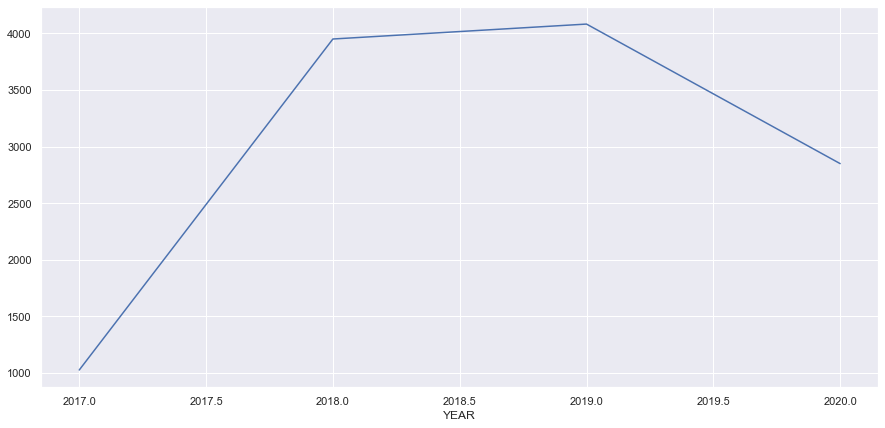

In [29]:
#plot data for Injuries Total
fig, ax = plt.subplots(figsize=(15,7))
train.groupby(['YEAR'])['INJURIES_TOTAL'].sum().plot(ax = ax)

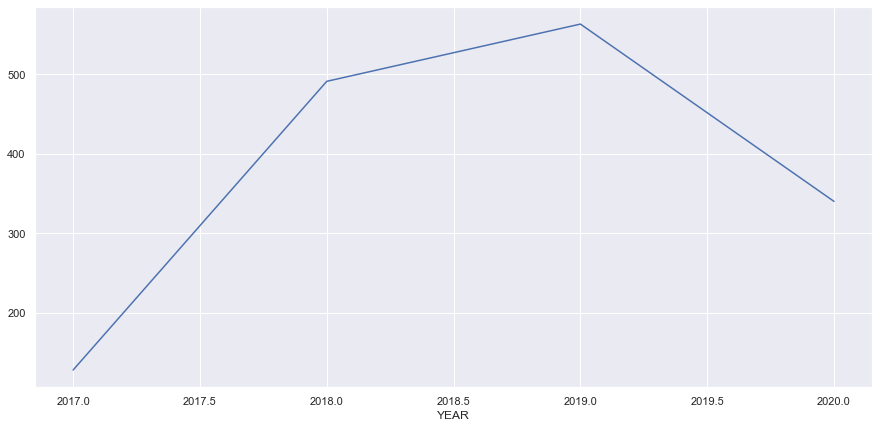

In [30]:
#plot data for Injuries Total
fig, ax = plt.subplots(figsize=(15,7))
train.groupby(['YEAR'])['TOTAL_FATAL'].sum().plot(ax = ax)

# Example Plots

In [41]:
df = train.groupby(['YEAR', 'PERSON_TYPE']).agg({'TOTAL_FATAL': 'sum'})
df
# Change: groupby state_office and divide by sum
df1 = df.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
df1.reset_index(inplace=True)
df1=df1[df1['PERSON_TYPE'].isin(['BICYCLE','DRIVER','PEDESTRIAN'])]

In [65]:
df1

,YEAR,PERSON_TYPE,TOTAL_FATAL
0,2017,BICYCLE,2.343750
1,2017,DRIVER,73.437500
4,2017,PEDESTRIAN,11.718750
6,2018,BICYCLE,3.054990
7,2018,DRIVER,76.171079
10,2018,PEDESTRIAN,11.405295
12,2019,BICYCLE,3.374778
13,2019,DRIVER,65.719361
16,2019,PEDESTRIAN,23.268206
18,2020,BICYCLE,3.529412


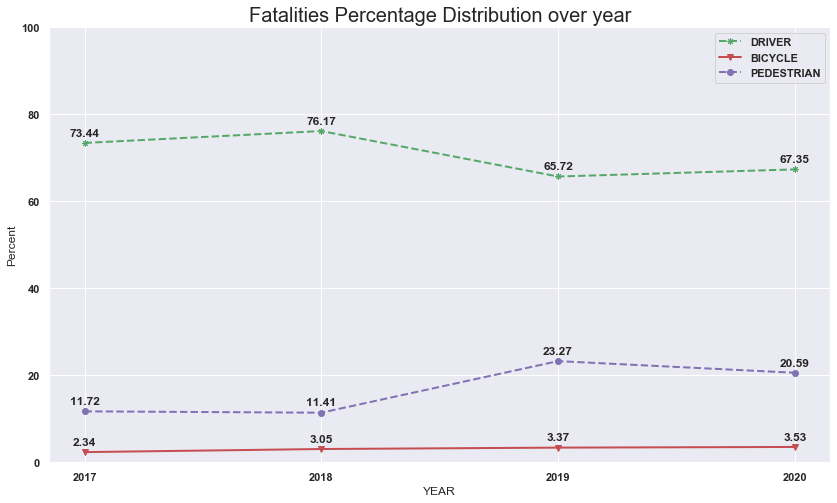

In [64]:
import matplotlib.pyplot as plt
import numpy as np

fig=plt.figure(figsize = (14,8))
ax=fig.add_subplot(111)

x= ['2017', '2018', '2019', '2020']
ax.plot(x,df1[df1['PERSON_TYPE']=='DRIVER']['TOTAL_FATAL'],c='g',marker=(8,2,0),ls='--', linewidth=2,label='DRIVER')
ax.plot(x,df1[df1['PERSON_TYPE']=='BICYCLE']['TOTAL_FATAL'],c='r',marker="v",ls='-', linewidth=2,label='BICYCLE')
ax.plot(x,df1[df1['PERSON_TYPE']=='PEDESTRIAN']['TOTAL_FATAL'],c='m',marker="o",ls='--', linewidth=2,label='PEDESTRIAN')

ax.set_xlabel("YEAR")
ax.set_ylabel("Percent")
ax.set_ylim(0,100)
plt.legend(loc=1)
plt.title("Fatalities Percentage Distribution over year",fontsize=20)

space = 5
va = 'bottom'
 
for i in range(0,3):
    line = ax.lines[i]
    for x_value, y_value in zip(line.get_xdata(), line.get_ydata()):
        label = "{:.2f}".format(y_value)
        ax.annotate(label,(x_value, y_value), xytext=(0, space), 
            textcoords="offset points", ha='center', va=va)

plt.show()

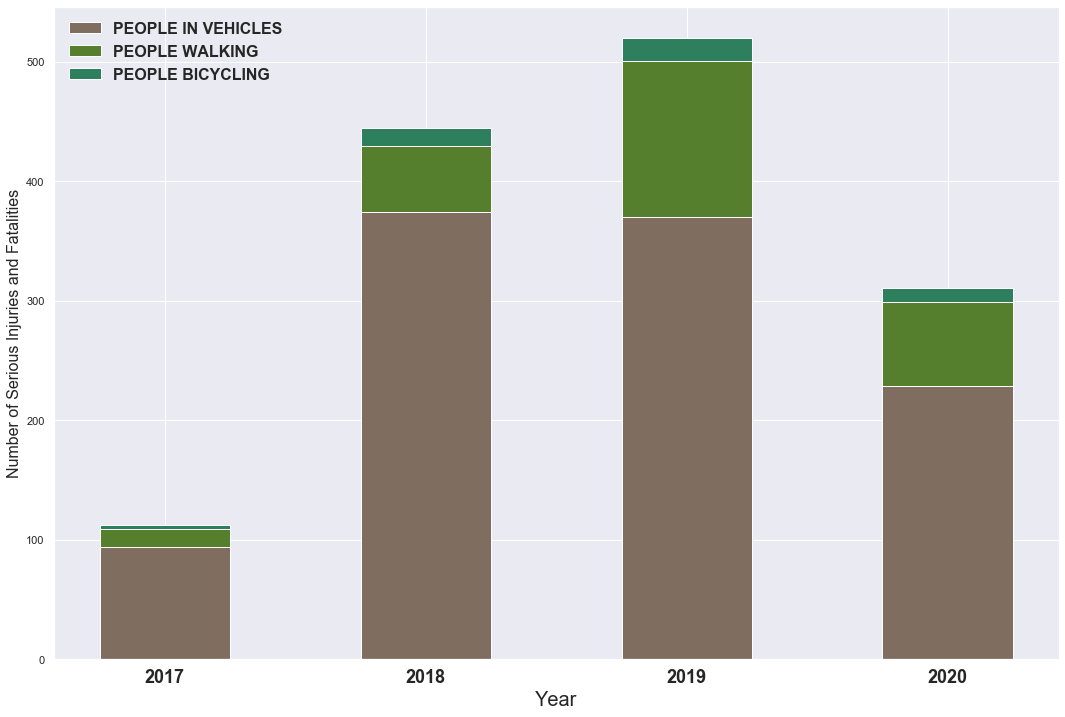

In [32]:
from matplotlib import rc
 
plt.subplots(figsize=(18,12))
    
# y-axis in bold
rc('font', weight='bold')
 
# Values of each group
bars1 = [94, 374, 370, 229]
bars2 = [15, 56, 131, 70]
bars3 = [3, 15, 19, 12]
 
# Heights of bars1 + bars2
bars = np.add(bars1, bars2).tolist()
 
# The position of the bars on the x-axis
r = [0,2,4,6]
 
# Names of group and bar width
names = ['2017','2018','2019','2020']
barWidth = 1
 
# Create brown bars
plt.bar(r, bars1, color='#7f6d5f', edgecolor='white', width=barWidth, label='PEOPLE IN VEHICLES')
# Create green bars (middle), on top of the firs ones
plt.bar(r, bars2, bottom=bars1, color='#557f2d', edgecolor='white', width=barWidth, label='PEOPLE WALKING')
# Create green bars (top)
plt.bar(r, bars3, bottom=bars, color='#2d7f5e', edgecolor='white', width=barWidth, label='PEOPLE BICYCLING')
 
# Custom X axis
plt.xticks(r, names, fontweight='bold', fontsize=18)
plt.xlabel("Year", fontsize=20)
plt.ylabel("Number of Serious Injuries and Fatalities", fontsize=16)
plt.legend(loc='upper left', frameon=False, fontsize=16)
 
# Show graphic
plt.show()

# Trial & Error Area

In [ ]:
#train.groupby(['YEAR', 'PERSON_TYPE'])['TOTAL_FATAL'].sum()

#train[train['TOTAL_FATAL']>=1][['YEAR', 'PERSON_TYPE']].value_counts(normalize=True).reset_index(name='total_fatal')